In [ ]:
#Descargamos el archivo desde el drive
!gdown https://drive.google.com/u/0/uc?id=1-kduva3Ji4ia1kFeKvYh_4AhIYwqb2Sa&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1-kduva3Ji4ia1kFeKvYh_4AhIYwqb2Sa
To: /content/tweet_emotions.csv
100% 3.77M/3.77M [00:00<00:00, 79.8MB/s]


##Importaciones y descargas

In [ ]:
import pandas as pd
import nltk
import pickle
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('names')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

##Dataset

In [ ]:
dataset = pd.read_csv("/content/tweet_emotions.csv")
dataset

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [ ]:
dataset['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
#Limpieza del dataset para poder trabajar con el mas adelante
#Se elimino una columna y 11 sentimientos
data_frame = dataset.drop(['tweet_id'], axis=1)
classes_to_remove = ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'relief', 'hate', 'surprise', 'love', 'happiness', 'sadness']

data_frame = data_frame[~data_frame['sentiment'].isin(classes_to_remove)]

data_frame

,sentiment,content
4,neutral,@dannycastillo We want to trade with someone w...
5,worry,Re-pinging @ghostridah14: why didn't you go to...
7,worry,Hmmm. http://www.djhero.com/ is down
10,neutral,cant fall asleep
11,worry,Choked on her retainers
...,...,...
39990,neutral,@shonali I think the lesson of the day is not ...
39991,neutral,@lovelylisaj can you give me the link for the ...
39992,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."


In [ ]:
word_tokenize('wants to hang out with friends SOON!')

['wants', 'to', 'hang', 'out', 'with', 'friends', 'SOON', '!']

In [ ]:
data_frame['sentiment'].value_counts()

neutral    8638
worry      8459
Name: sentiment, dtype: int64

##Limpieza

In [ ]:
stoplist = nltk.corpus.stopwords.words("english")
names = nltk.corpus.names.words()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
#Listado de tokens que no quiero que aparezcan
unwanted_tokens = ["http", "u", "lol", "amp", "ca", "na", "twitter",
                   "lt", "hey", "tweet", "ur", "wan", "gon", "wo",
                   "x", "ya", "ta", "n", "yes", "gt", "okay", "r",
                   "xx", "b", "p", "la", "le", "wa"]

In [ ]:
#Se crea una funcion para empezar el proceso de limpiado y lematizacion
from nltk.stem.snowball import stopwords
def get_tokens(text):

  tokens = word_tokenize(text)
  cleaned_tokens = []

  for token in tokens:
    if token in stoplist: continue
    if token in names: continue
    if not token.isalpha(): continue
    if token in unwanted_tokens: continue
    token = token.lower()
    token = lemmatizer.lemmatize(token)
    #token = stemmer.stem(token)
    cleaned_tokens.append(token)

  #cleaned_tokens = [i for i in pos_tag(cleaned_tokens) if i [1][:2] in ["RB", "VB", "JJ", "NN"]]

  return cleaned_tokens

In [ ]:
data_frame['content'].iloc[400]

'Ran out of money. I r a sad panda'

In [ ]:
get_tokens(data_frame['content'].iloc[400])

['ran', 'money', 'i', 'sad', 'panda']

In [ ]:
#Se construye el vocabulario en base a las categorias
vocabulary = {sentiment:[] for sentiment in data_frame['sentiment']. unique()}
complete_vocabulary = []

for _, row in data_frame.iterrows():
  tokens = get_tokens(row['content'])
  vocabulary[row['sentiment']] += tokens
  complete_vocabulary += tokens

In [ ]:
len(set(complete_vocabulary))

20957

##Instancias Pickle

In [ ]:
#For para crear los pickle
for category in vocabulary:
  FeelingMostCommon = [i[0] for i in FreqDist(vocabulary[category]).most_common(500)]
  with open(f'FeelingMostCommon_{category}.pkl', 'wb') as file:
    pickle.dump(FeelingMostCommon, file)

In [ ]:
FeelingMostCommon_neutral = [i[0] for i in FreqDist(vocabulary['neutral']).most_common(1000)]
FeelingMostCommon_worry = [i[0] for i in FreqDist(vocabulary['worry']).most_common(1000)]

In [ ]:
#nltk.help.upenn_tagset()

In [ ]:
#FreqDist(get_tokens(data_frame['content'].iloc[77]))

##Entrenamiento del modelo

In [ ]:
#Creacion de un set que reune los tokens mas comunes en los sentimientos 'Neutral' y 'Worry'
most_common_tokens = list(set(FeelingMostCommon_neutral + FeelingMostCommon_worry))
len(most_common_tokens)

1207

In [ ]:
#Funcion de entrenamiento donde ya se trabaja con los tokens limpios
def get_tokens_training(text):

  tokens = word_tokenize(text)
  cleaned_tokens = []

  for token in tokens:
    if token in stoplist: continue
    if token in names: continue
    if not token.isalpha(): continue
    token = token.lower()
    token = lemmatizer.lemmatize(token)
    if token not in most_common_tokens: continue
    cleaned_tokens.append(token)


    #cleaned_tokens = [i for i in cleaned_tokens if token in most_common_tokens]

#Aca lo que me retorna es cada token en un input separado por espacios
  return " ".join(cleaned_tokens)

In [ ]:
#Creacion de columna nueva con la funcion lambda donde cada token en un input se divide por espacios
data_frame['Tokens String'] = data_frame['content'].apply(lambda x: get_tokens_training(x))
data_frame['Tokens String']

4                               we want someone ticket one
5                                   go prom bc like friend
7                                                     hmmm
10                                        cant fall asleep
11                                                        
                               ...                        
39990                                   i think lesson day
39991                                     give link please
39992    showing lol thing good lovely weather outside ...
39993             haha yeah twitter many for know ppl care
39995                                                     
Name: Tokens String, Length: 17097, dtype: object

In [ ]:
# Concatena las muestras de todas las clases en un nuevo DataFrame

df_training = pd.concat([
  data_frame[data_frame["sentiment"] == "neutral"].sample(8450),
  data_frame[data_frame["sentiment"] == "worry"].sample(8450),
]).reset_index(drop=True)

In [ ]:
#Vectorizando la data
vectorizer = TfidfVectorizer(vocabulary=most_common_tokens)
X = vectorizer.fit_transform(data_frame['Tokens String'])
X

<17097x1207 sparse matrix of type '<class 'numpy.float64'>'
	with 79434 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape

(17097, 1207)

In [ ]:
y = data_frame['sentiment']
y

4        neutral
5          worry
7          worry
10       neutral
11         worry
          ...   
39990    neutral
39991    neutral
39992    neutral
39993    neutral
39995    neutral
Name: sentiment, Length: 17097, dtype: object

##Modelos de entrenamiento

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
#Buscando el accuracy de los 10 modelos seleccionados para saber cual de estos es mas eficiente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

models= [AdaBoostClassifier(), KNeighborsClassifier(),RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), MultinomialNB(),
         SVC(), LogisticRegression(), GradientBoostingClassifier(), lgb.LGBMClassifier()]

for model in models:
  model.fit(X_train.toarray(), y_train)
  y_pred = model.predict(X_test.toarray())
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Model: {model.__class__.__name__}, Accuracy: {accuracy}")

Model: AdaBoostClassifier, Accuracy: 0.6371345029239766
Model: KNeighborsClassifier, Accuracy: 0.5228070175438596
Model: RandomForestClassifier, Accuracy: 0.6488304093567251
Model: DecisionTreeClassifier, Accuracy: 0.6002923976608188
Model: GaussianNB, Accuracy: 0.6307017543859649
Model: MultinomialNB, Accuracy: 0.6488304093567251
Model: SVC, Accuracy: 0.6657894736842105
Model: LogisticRegression, Accuracy: 0.6649122807017543
Model: GradientBoostingClassifier, Accuracy: 0.6453216374269006
[LightGBM] [Info] Number of positive: 6764, number of negative: 6913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19864
[LightGBM] [Info] Number of data points in the train set: 13677, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494553 -> initscore=-0.021789
[L

In [ ]:
#Creacion de la matriz de confusion perteneciente a cada modelo
for model in models:
  matrix = confusion_matrix(y_test, model.predict(X_test.toarray()))
  print(f"Model: {model.__class__.__name__}, Confusion Matrix: \n{matrix}")

Model: AdaBoostClassifier, Confusion Matrix: 
[[1364  361]
 [ 880  815]]
Model: KNeighborsClassifier, Confusion Matrix: 
[[1541  184]
 [1448  247]]
Model: RandomForestClassifier, Confusion Matrix: 
[[1093  632]
 [ 569 1126]]
Model: DecisionTreeClassifier, Confusion Matrix: 
[[1045  680]
 [ 687 1008]]
Model: GaussianNB, Confusion Matrix: 
[[1267  458]
 [ 805  890]]
Model: MultinomialNB, Confusion Matrix: 
[[1184  541]
 [ 660 1035]]
Model: SVC, Confusion Matrix: 
[[1214  511]
 [ 632 1063]]
Model: LogisticRegression, Confusion Matrix: 
[[1204  521]
 [ 625 1070]]
Model: GradientBoostingClassifier, Confusion Matrix: 
[[1480  245]
 [ 968  727]]
Model: LGBMClassifier, Confusion Matrix: 
[[1261  464]
 [ 718  977]]


In [ ]:
#Creando un reporte de clasificacion para cada modelo
for model in models:
  report = classification_report(y_test, model.predict(X_test.toarray()))
  print(f"Model: {model.__class__.__name__}, Classification Report: \n{report}")

Model: AdaBoostClassifier, Classification Report: 
              precision    recall  f1-score   support

     neutral       0.61      0.79      0.69      1725
       worry       0.69      0.48      0.57      1695

    accuracy                           0.64      3420
   macro avg       0.65      0.64      0.63      3420
weighted avg       0.65      0.64      0.63      3420

Model: KNeighborsClassifier, Classification Report: 
              precision    recall  f1-score   support

     neutral       0.52      0.89      0.65      1725
       worry       0.57      0.15      0.23      1695

    accuracy                           0.52      3420
   macro avg       0.54      0.52      0.44      3420
weighted avg       0.54      0.52      0.44      3420

Model: RandomForestClassifier, Classification Report: 
              precision    recall  f1-score   support

     neutral       0.66      0.63      0.65      1725
       worry       0.64      0.66      0.65      1695

    accuracy           

In [ ]:
#Guardando todos los modelos en archivos pickle
for model in models:
  with open(f'Model_{model.__class__.__name__}.pkl', 'wb') as file:
    pickle.dump(model, file)

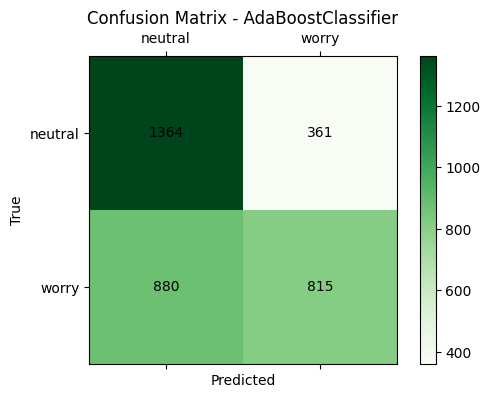

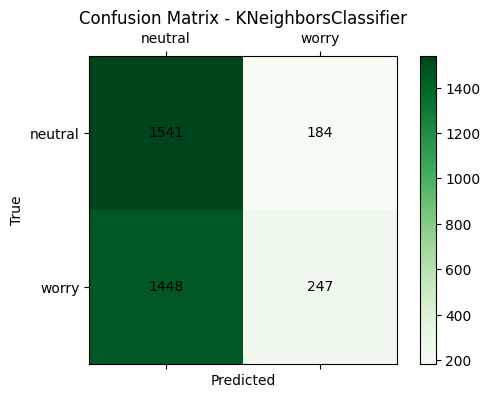

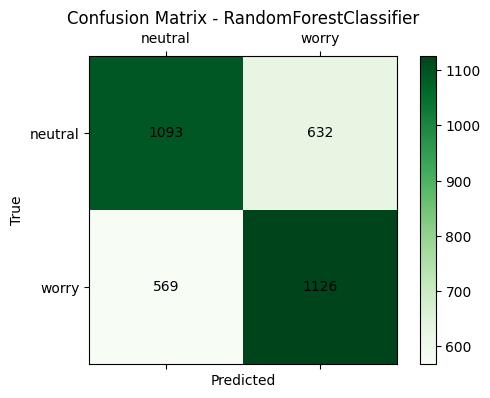

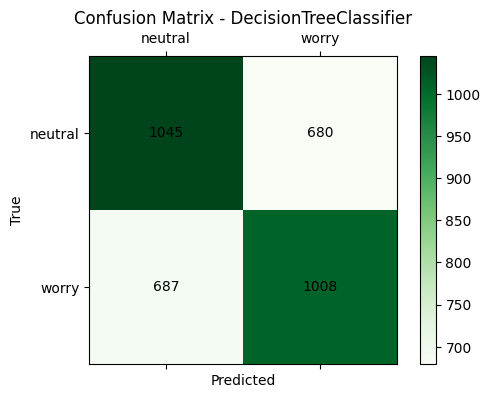

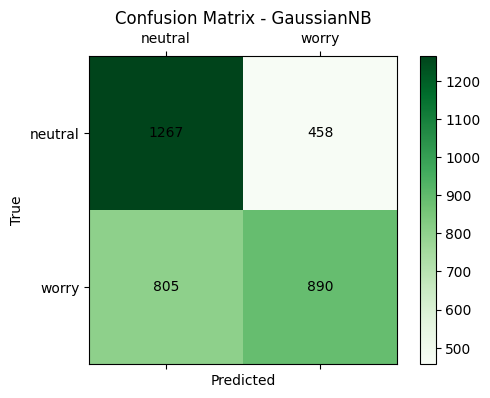

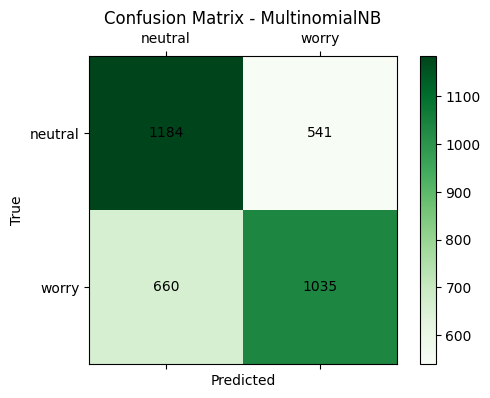

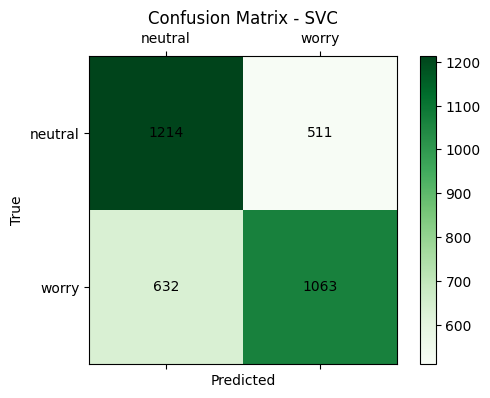

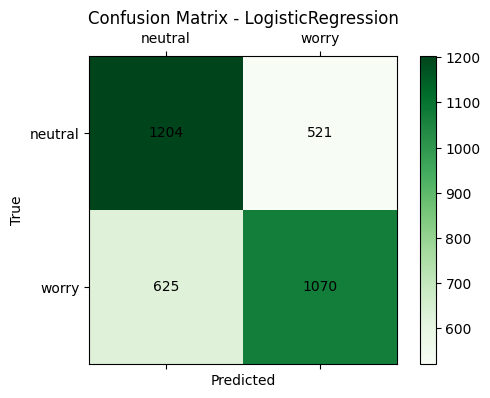

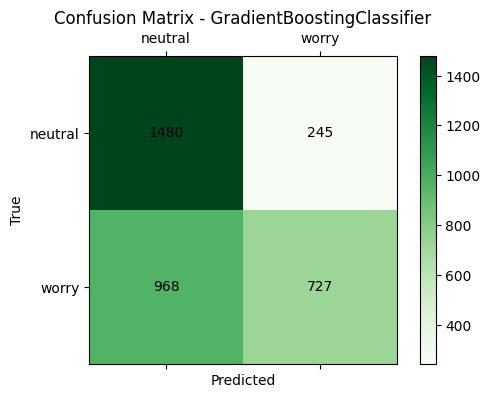

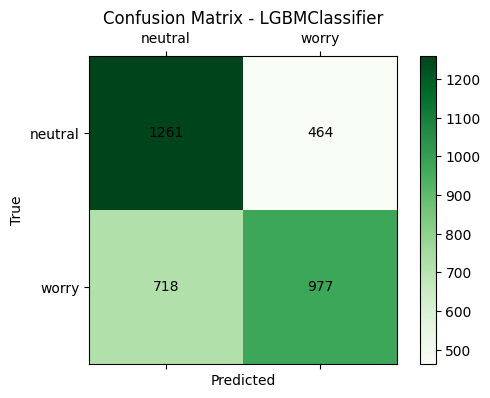

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Itera a través de los modelos
for model in models:
    matrix = confusion_matrix(y_test, model.predict(X_test.toarray()))
    model_name = model.__class__.__name__

# Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(6, 4))

    # Crear la matriz de colores
    cax = ax.matshow(matrix, cmap=plt.cm.Greens)

    # Mostrar los valores en las celdas
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, str(matrix[i, j]), va='center', ha='center')

    # Configurar etiquetas de los ejes
    classes = np.unique(y_test)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Etiquetas de los ejes
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Título
    plt.title(f'Confusion Matrix - {model_name}')

    # Mostrar la barra de color
    fig.colorbar(cax)

    plt.show()

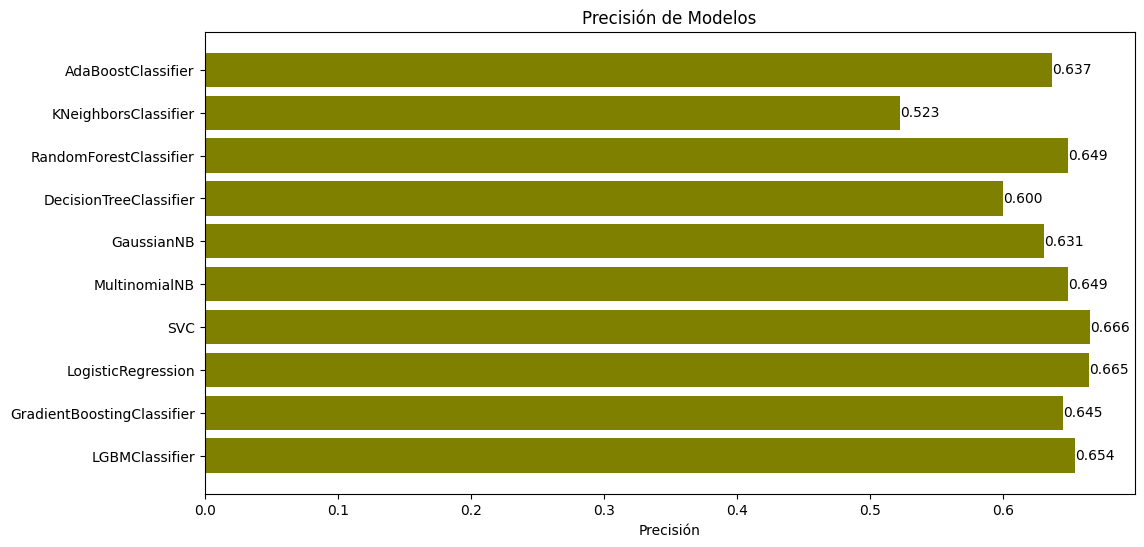

In [ ]:
#Grafica para ver los modelos y su presicion:

# Extraemos nombres de modelos y porcentajes de precisión
model_names = [model.__class__.__name__ for model in models]
precisions = [accuracy_score(y_test, model.predict(X_test.toarray())) for model in models]

# Creacion del gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(model_names, precisions, color='olive')
plt.xlabel('Precisión')
plt.title('Precisión de Modelos')
plt.gca().invert_yaxis()  # Invertir el eje y para que el modelo con la mayor precisión esté en la parte superior

# Agregar etiquetas en cada barra
for i, precision in enumerate(precisions):
    plt.text(precision, i, f"{precision:.3f}", ha='left', va='center')

plt.show()

##"Modelo en production"

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.probability import FreqDist
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [ ]:
#Cargando los modelos pickle tanto de los modelos como de los sentimientos comunes mas usados
loaded_model = {}
loaded_common_feelings = {}
for model in models:
  with open(f'Model_{model.__class__.__name__}.pkl', 'rb') as file:
    loaded_model[model.__class__.__name__] = pickle.load(file)
  with open(f'FeelingMostCommon_{category}.pkl', 'rb') as file:
    loaded_common_feelings[category] = pickle.load(file)

In [ ]:
print(loaded_model)

{'AdaBoostClassifier': AdaBoostClassifier(), 'KNeighborsClassifier': KNeighborsClassifier(), 'RandomForestClassifier': RandomForestClassifier(), 'DecisionTreeClassifier': DecisionTreeClassifier(), 'GaussianNB': GaussianNB(), 'MultinomialNB': MultinomialNB(), 'SVC': SVC(), 'LogisticRegression': LogisticRegression(), 'GradientBoostingClassifier': GradientBoostingClassifier(), 'LGBMClassifier': LGBMClassifier()}


In [ ]:
stoplist = nltk.corpus.stopwords.words("english")
names = nltk.corpus.names.words()
lemmatizer = WordNetLemmatizer()

data = {'stopwords': stopwords, 'names': names}
with open('nltk_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
#Cargando la funcion utilizada en el entrenamiento para volver a limpiar la data en produccion
def get_tokens_prediction(text):

  tokens = word_tokenize(text)
  cleaned_tokens = []

  for token in tokens:
    if token in stoplist: continue
    if token in names: continue
    if not token.isalpha(): continue
    token = token.lower()
    token = lemmatizer.lemmatize(token)
    if token not in most_common_tokens: continue
    cleaned_tokens.append(token)

  return " ".join(cleaned_tokens)

In [ ]:
#Cargando el dataset completo
predict_df = pd.read_csv("/content/tweet_emotions.csv")

In [ ]:
get_tokens_prediction(predict_df.iloc[400]['content'])

'it good holiday look v one going home today'

In [ ]:
predict_df["Tokens String"] = predict_df["content"].apply(lambda x: get_tokens_prediction(x))

In [ ]:
#vectorizacion again
vectorizer = TfidfVectorizer(vocabulary=most_common_tokens)
X = vectorizer.fit_transform(predict_df["Tokens String"])

In [ ]:
predictions = model.predict(X)

In [ ]:
print(predict_df)

         tweet_id   sentiment  \
0      1956967341       empty   
1      1956967666     sadness   
2      1956967696     sadness   
3      1956967789  enthusiasm   
4      1956968416     neutral   
...           ...         ...   
39995  1753918954     neutral   
39996  1753919001        love   
39997  1753919005        love   
39998  1753919043   happiness   
39999  1753919049        love   

                                                 content  \
0      @tiffanylue i know  i was listenin to bad habi...   
1      Layin n bed with a headache  ughhhh...waitin o...   
2                    Funeral ceremony...gloomy friday...   
3                   wants to hang out with friends SOON!   
4      @dannycastillo We want to trade with someone w...   
...                                                  ...   
39995                                   @JohnLloydTaylor   
39996                     Happy Mothers Day  All my love   
39997  Happy Mother's Day to all the mommies out ther...   
399

In [ ]:
#concatenacion de las columnas tokens string y prediction en el data set
pd.concat([predict_df, pd.Series(predictions, name="Prediction")], axis=1)

,tweet_id,sentiment,content,Tokens String,Prediction
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,know bad earlier started part,worry
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,bed headache call,worry
2,1956967696,sadness,Funeral ceremony...gloomy friday...,friday,worry
3,1956967789,enthusiasm,wants to hang out with friends SOON!,want hang friend soon,neutral
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,we want someone ticket one,neutral
...,...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,,neutral
39996,1753919001,love,Happy Mothers Day All my love,mother day all love,worry
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,mother day mommy woman man long someone day,neutral
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,beautiful follow me peep out my new hit single...,worry


##Information no longer needed from here on

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
"""vocabulario = []

for i in data_frame['content']:
  vocabulario += get_tokens(i)

FreqDist(vocabulario).most_common(500)"""

"vocabulario = []\n\nfor i in data_frame['content']:\n  vocabulario += get_tokens(i)\n\nFreqDist(vocabulario).most_common(500)"

In [ ]:
# Lista de las clases que deseas mantener
'''classes_to_keep = ['neutral', 'worry', 'happiness', 'sadness', 'love']

# Inicializa una lista vacía para almacenar las muestras de cada clase
samples_per_class = []

# Itera a través de las clases y toma una muestra de cada una
for class_name in classes_to_keep:
    sampled_data = data_frame[data_frame["sentiment"] == class_name].sample(5)
    samples_per_class.append(sampled_data)


# Crear un DataFrame con la data original
data = pd.DataFrame({'sentiment': ['neutral', 'worry', 'happiness', 'sadness', 'love'],
                     'count': [8638, 8459, 5209, 5165, 3842]})

# Establecer el número objetivo de muestras por clase
target_count = 8635

# Crear listas para almacenar los DataFrames de cada clase
class_dfs = []

# Realizar upsampling para las clases 'happiness', 'sadness' 'love'
for sentiment in ['happiness', 'sadness', 'love']:
    class_df = data[data['sentiment'] == sentiment]
    oversampled_df = resample(class_df, replace=True, n_samples=target_count, random_state=0)
    class_dfs.append(oversampled_df)

# Mantener el DataFrame original para las clases restantes
class_dfs.append(data[data['sentiment'].isin(['neutral'])])

# Concatenar todos los DataFrames en uno nuevo
df_training = pd.concat(class_dfs)

# Resultado: df_training contiene las clases 'happiness', 'love' y 'sadness' con 8,635 muestras'''

'classes_to_keep = [\'neutral\', \'worry\', \'happiness\', \'sadness\', \'love\']\n\n# Inicializa una lista vacía para almacenar las muestras de cada clase\nsamples_per_class = []\n\n# Itera a través de las clases y toma una muestra de cada una\nfor class_name in classes_to_keep:\n    sampled_data = data_frame[data_frame["sentiment"] == class_name].sample(5)\n    samples_per_class.append(sampled_data)\n\n\n# Crear un DataFrame con la data original\ndata = pd.DataFrame({\'sentiment\': [\'neutral\', \'worry\', \'happiness\', \'sadness\', \'love\'],\n                     \'count\': [8638, 8459, 5209, 5165, 3842]})\n\n# Establecer el número objetivo de muestras por clase\ntarget_count = 8635\n\n# Crear listas para almacenar los DataFrames de cada clase\nclass_dfs = []\n\n# Realizar upsampling para las clases \'happiness\', \'sadness\' \'love\'\nfor sentiment in [\'happiness\', \'sadness\', \'love\']:\n    class_df = data[data[\'sentiment\'] == sentiment]\n    oversampled_df = resample(clas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ValueError: ignored

In [ ]:
model = GaussianNB()
model.fit(X_train.toarray(), y_train)

In [ ]:
#probabilidad a priori de las clases
model.class_prior_

In [ ]:
#clases a trabajar
model.classes_

In [ ]:
#Testeando la prediccion del modelo
model.predict(X_test.toarray())

In [ ]:
#no se usa
'''accuracy_score(y_test, model.predict(X_test.toarray()))
precision_score(y_test, model.predict(X_test.toarray()), pos_label="worry")
recall_score(y_test, model.predict(X_test.toarray()), pos_label="neutral")'''

In [ ]:
#reporte del modelo
print(classification_report(y_test, model.predict(X_test.toarray())))

In [ ]:
#matriz de confunsion
confusion_matrix(y_test, model.predict(X_test.toarray()))

In [ ]:
#creacion de un archivo pickle para guardar el modelo
with open("model_naive_bayes.pkl", "wb") as file:
  pickle.dump(model, file)

In [ ]:
#A la hora de vectorizar practicar con lo siguiente para los sentimientos:
#Upsampling
#Downsampling
#Tomar unicamente las que tengan mayor numero de datos
#Hacer union de sentimientos como por ejemplo happiness puede tener enthusiasm junto

#Al final comparar toda esa data para ver resultados y encontrar la mejor forma para presentar la data

##Multinomial Naive Bayes

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [ ]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
modelo_2 = GaussianNB()
y_pred = modelo_2.fit(X_train, y_train)

In [ ]:
accuracy_score(y_test, modelo_2.predict(X_test))

In [ ]:
#probabilidad a priori de las clases
modelo_2.class_prior_

In [ ]:
#clases a trabajar
modelo_2.classes_

In [ ]:
#Testeando la prediccion del modelo
modelo_2.predict(X_test)

In [ ]:
#reporte del modelo
print(classification_report(y_test, modelo_2.predict(X_test)))

In [ ]:
#matriz de confusion
confusion_matrix(y_test, modelo_2.predict(X_test))

In [ ]:
#creacion de un archivo pickle para guardar el modelo
with open("model_multinomial_naive_bayes.pkl", "wb") as file:
  pickle.dump(model, file)

##AdaBoostClassifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

##Decision Tree Classifier

In [ ]:
from sklearn import tree
x = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x, Y)
clf

In [ ]:
clf.predict([[2., 2.]])

In [ ]:
clf.predict_proba([[2., 2.]])

In [ ]:
tree.plot_tree(clf)

##Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
W = [[0, 0], [1, 1]]
Z = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(W, Z)
clf

##KNearest Neighbors Classifier

In [ ]:
X = [[0], [1], [2], [3]]
>>> y = [0, 0, 1, 1]
>>> from sklearn.neighbors import KNeighborsClassifier
>>> neigh = KNeighborsClassifier(n_neighbors=3)
>>> neigh.fit(X, y)
KNeighborsClassifier(...)
>>> print(neigh.predict([[1.1]]))
[0]
>>> print(neigh.predict_proba([[0.9]]))